# 00

In [ ]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, Adadelta, SGD
from torch.profiler import profile, record_function, ProfilerActivity

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution

In [2]:

LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test11/logs/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'training00.log'), 
    level=logging.INFO
)

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test11/checkpoints/")
VERBOSE_RATE = 1000

(H_train, W_train) = (128, 128)
(H_val, W_val) = (256, 256)
(H_test, W_test) = (496, 996)

train_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="addictive_noise_scale",
    lambda_noise=25.0,
    patch_size=H_train,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

validation_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/CBSD68_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_val,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

test_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_test,
    patch_overlap_size=0,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)


data_train_batched = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, num_workers=4
)

data_valid_batched = torch.utils.data.DataLoader(
    validation_dataset, batch_size=16, num_workers=4
)

data_test_batched = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=4
)

In [13]:
import itertools
import collections
import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.profiler import profile, record_function, ProfilerActivity
# torch.set_default_dtype(torch.float64)

from einops import rearrange


class GLRFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device,
            M_diag_init=0.4
        ):
        super(GLRFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


        ### Trainable parameters
        # features on nodes
        self.multiM = Parameter(
            torch.diag_embed(torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32))*M_diag_init,
            requires_grad=True,
        )

        #############
        avg_kernel = 1.0 * torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0],
        ])
        delta_x = 0.5 * torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0,-1.0, 1.0],
            [0.0, 0.0, 0.0],
        ])
        delta_y = 0.5 * torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0,-1.0, 0.0],
            [0.0, 1.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(avg_kernel[np.newaxis, np.newaxis, :, :])
            kernel.append(delta_x[np.newaxis, np.newaxis, :, :])
            kernel.append(delta_y[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel = Parameter(
            torch.ones((3*self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel,
            requires_grad=True,
        )

    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        neighbors_pixels = []
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            neighbors_pixels.append(
                img_features_frame[:, :, fromh:toh, fromw:tow]
            )
        neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)

        return neighbors_pixels_features
    

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hcv -> bhvHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.reshape(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)


        features_similarity = torch.clip(features_similarity, max=10, min=-10)
        edge_weights = torch.exp(features_similarity)

        node_degree = edge_weights.sum(axis=2)

        # norm_factor = 1.0 / torch.sqrt(node_degree)
        # norm_factor_neighbors = self.get_neighbors_pixels(norm_factor)
        # edge_weights_norm = norm_factor[:, :, None, :, :] * edge_weights * norm_factor_neighbors

        norm_factor = 1.0 / node_degree
        edge_weights_norm = norm_factor[:, :, None, :, :] * edge_weights
        
        return edge_weights_norm, node_degree
    


    def op_L_norm(self, img_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Wx = torch.einsum(
            "bhceHW, bheHW -> bhcHW", img_features_neighbors, edge_weights
        )
        output = img_signals - Wx
        return output

    
    def stats_conv(self, patchs):
        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
        temp_patch = patchs.view(batch_size*n_graphs, c_size, h_size, w_size)
        temp_patch = nn.functional.pad(temp_patch, (1,1,1,1), 'reflect')
        temp_out_patch = nn.functional.conv2d(
            temp_patch,
            weight=self.stats_kernel,
            stride=1,
            padding=0,
            dilation=1,
            groups=self.n_channels,
        )
        out_patch = temp_out_patch.view(batch_size, n_graphs, 3*c_size, h_size, w_size)
        return out_patch

    def stats_conv_transpose(self, patchs):
        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
        temp_patch = patchs.reshape(batch_size*n_graphs, c_size, h_size, w_size)
        temp_out_patch = nn.functional.conv_transpose2d(
            temp_patch,
            weight=self.stats_kernel,
            stride=1,
            padding=1,
            dilation=1,
            groups=self.n_channels,
        )
        out_patch = temp_out_patch.view(batch_size, n_graphs, c_size//3, h_size, h_size)
        return out_patch


    def forward(self, patchs, edge_weights, node_degree):
        # with record_function("GLR:forward"): 
        # F
        # batch_size, n_graphs, c_size, h_size, w_size = patchs.shape

        patchs = self.stats_conv(patchs)
        # L
        output_patchs = self.op_L_norm(patchs, edge_weights, node_degree)
        
        # F^T
        output_patchs = self.stats_conv_transpose(output_patchs)
        return output_patchs


def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma+1e-5) * self.weight

class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)


class Extractor(nn.Module):
    def __init__(self, n_features_in, n_features_out, n_channels_in, n_channels_out, device):
        super(Extractor, self).__init__()

        self.device         = device
        # self.kernel_size    = 3
        # self.stride         = 2
        # self.padding        = 1
        self.n_features_in  = n_features_in
        self.n_features_out = n_features_out
        self.n_channels_in  = n_channels_in
        self.n_channels_out = n_channels_out
        
        # Downsampler kernel
        self.down_sampling_kernel = Parameter(
            torch.ones((n_channels_out, 1, 3, 3), device=self.device, dtype=torch.float32) * (1/9),
            requires_grad=True,
        )
    
        # Features extractor
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=n_features_in, 
                out_channels=n_features_out//4, 
                kernel_size=3,
                stride=1,
                padding=1,
                dilation=1,
                padding_mode="zeros",
                bias=False
            ),
            nn.PixelUnshuffle(2),
            LayerNorm(n_features_out, 'BiasFree')
        ).to(self.device)

    def downsampling(self, input_patchs):
        output_patchs = nn.functional.conv2d(
            input_patchs,
            weight=self.down_sampling_kernel,
            stride=2,
            padding=1,
            dilation=1,
            groups=self.n_channels_in,
        )
        return output_patchs

    def upsampling(self, input_patchs):
        output_patchs = nn.functional.conv_transpose2d(
            input_patchs,
            weight=self.down_sampling_kernel,
            stride=2,
            padding=0,
            dilation=1,
            groups=self.n_channels_in,
        )[:, :, 1:, 1:]
        return output_patchs

    def forward(self, input_features_patchs):
        # with record_function("Extractor:forward"): 
        output_features_patchs = self.cnn_layer(input_features_patchs)
        return output_features_patchs


class MultiScaleMixtureGLR(nn.Module):
    def __init__(self, n_levels, n_graphs, n_cgd_iters, alpha_init, beta_init, muy_init, device, GLR_modules_conf=[],  Extractor_modules_conf=[]):
        super(MultiScaleMixtureGLR, self).__init__()

        self.device      = device
        self.n_levels    = n_levels
        self.n_graphs    = n_graphs
        self.n_cgd_iters = n_cgd_iters
        self.nchannels_images  = 3
        self.nchannels_abtract = Extractor_modules_conf[0]["ExtractorConf"]["n_channels_in"]


        self.muys = Parameter(
            torch.ones((self.n_levels, n_graphs), device=self.device, dtype=torch.float32) * muy_init,
            requires_grad=True,
        )

        self.alphaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * alpha_init,
            requires_grad=True
        )

        self.betaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * beta_init,
            requires_grad=True
        )

        self.combination_weight = Parameter(
            torch.ones((self.n_graphs), device=self.device, dtype=torch.float32)/self.n_graphs,
            requires_grad=True,
        )

        self.patchs_embeding = nn.Conv2d(
            Extractor_modules_conf[0]["ExtractorConf"]["n_channels_in"],
            Extractor_modules_conf[0]["ExtractorConf"]["n_features_in"], 
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        ).to(self.device)

        self.list_mixtureGLR = nn.ModuleList([])
        for level in range(self.n_levels): 
            glr_module = GLRFast(**GLR_modules_conf[level]["GLRConf"]) 
            # glr_module.compile()
            self.list_mixtureGLR.append(glr_module)

        self.list_Extractor = nn.ModuleList([])
        for level in range(self.n_levels-1):
            extractor_module = Extractor(**Extractor_modules_conf[level]["ExtractorConf"]) 
            # extractor_module.compile()
            self.list_Extractor.append(extractor_module)


    def apply_multi_scale_lightweight_transformer(self, patchs, list_graph_weights):
        
        # with record_function("MultiScaleMixtureGLR:apply_multi_scale_lightweight_transformer"): 
        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape 
        patchs = patchs.contiguous()
        
        list_2D_signals = [patchs]

        ###########################################################################
        # H
        # print(f"list_2D_signals[0].shape={patchs.shape}")
        downsampled_patchs = patchs
        for level in range(self.n_levels-1):

            extractor_module = self.list_Extractor[level]
            batch_size, n_graphs, c_size, h_size, w_size = downsampled_patchs.shape 

            downsampled_patchs = extractor_module.downsampling(
                downsampled_patchs.view(batch_size*n_graphs, c_size, h_size, w_size)
            )
            
            _, c_size_new, h_size_new, w_size_new = downsampled_patchs.shape 
            downsampled_patchs = downsampled_patchs.view(batch_size, n_graphs, c_size_new, h_size_new, w_size_new)

            list_2D_signals.append(downsampled_patchs)
            # print(f"list_2D_signals[{level+1}].shape={list_2D_signals[level+1].shape}")

        ###########################################################################
        # L
        list_2D_signals_L_transform = []
        for level in range(self.n_levels):
            glr_module = self.list_mixtureGLR[level]
            laplacian_2D_signals = glr_module(list_2D_signals[level], list_graph_weights[level][0], list_graph_weights[level][1])
            list_2D_signals_L_transform.append(laplacian_2D_signals)
            # print(f"list_2D_signals_L_transform[{level}].shape={list_2D_signals_L_transform[level].shape}")



        ###########################################################################
        # H^T
        upsampled_patchs = list_2D_signals_L_transform[self.n_levels-1]
        # print(f"upsampled_patchs[{self.n_levels-1}].shape={upsampled_patchs.shape}")
        for level in range(self.n_levels-2, -1, -1):

            extractor_module = self.list_Extractor[level]
            batch_size, n_graphs, c_size, h_size, w_size = upsampled_patchs.shape 

            upsampled_patchs = extractor_module.upsampling(
                upsampled_patchs.view(batch_size*n_graphs, c_size, h_size, w_size)
            )
            _, c_size_new, h_size_new, w_size_new = upsampled_patchs.shape
            upsampled_patchs = upsampled_patchs.view(batch_size, n_graphs, c_size_new, h_size_new, w_size_new)
            # print(f"upsampled_patchs[{level}].shape={upsampled_patchs.shape}")

            # print(f"concat({list_2D_signals_L_transform[level].shape}, {upsampled_patchs.shape})")
            upsampled_patchs = torch.concat([
                list_2D_signals_L_transform[level],
                upsampled_patchs,
            ], axis=1)
            # print(f"upsampled_patchs_cummulative.shape={upsampled_patchs.shape}")
    

        ###########################################################################
        # Sum of log experts <-> product of experts
        batch_size, _, c_size, h_size, w_size = upsampled_patchs.shape 
        upsampled_patchs_final = upsampled_patchs.view((batch_size, self.n_levels, self.n_graphs, c_size, h_size, w_size))
        # print(f"upsampled_patchs_final.shape={upsampled_patchs_final.shape}")
        
        outputLx = torch.einsum(
            "bLHchw, LH -> bHchw", upsampled_patchs_final, self.muys
        )
        output = patchs + outputLx
        # print(f"outputLx.shape={output.shape}")
        
        return output

    def forward(self, patchs):
        # with record_function("MultiScaleMixtureGLR:forward"): 
        # print("#"*80)
        patchs = patchs.permute(dims=(0, 3, 1, 2))
        # patchs = self.images_domain_to_abtract_domain(patchs)
        # print(f"patchs.shape={patchs.shape}")
        batch_size, c_size, h_size, w_size = patchs.shape

        features_patchs = self.patchs_embeding(patchs)
        glr_module = self.list_mixtureGLR[0]

        # print(f"features_patchs.shape={features_patchs.shape}")
        bz, nfts, h, w = features_patchs.shape
        gW, gD = glr_module.extract_edge_weights(
            features_patchs.view((bz, glr_module.n_graphs, glr_module.n_node_fts, h, w))
        )
        # print(f"gW.shape={gW.shape} gD.shape={gD.shape}")
        list_graph_weights = [(gW, gD)]
        for level in range(self.n_levels-1):
            # print("#"*80)
            ###
            extractor_module = self.list_Extractor[level]
            glr_module = self.list_mixtureGLR[level+1]

            ###
            features_patchs = extractor_module(features_patchs)
            # print(f"features_patchs.shape={features_patchs.shape}")
            bz, nfts, h, w = features_patchs.shape
            gW, gD = glr_module.extract_edge_weights(
                features_patchs.view((bz, glr_module.n_graphs, glr_module.n_node_fts, h, w))
            )

            # print(f"gW.shape={gW.shape} gD.shape={gD.shape}")
            list_graph_weights.append((gW, gD))

        
        # print("#"*80)

        output = patchs[:, None, :, :, :]
        system_residual = output -  self.apply_multi_scale_lightweight_transformer(output, list_graph_weights)
        update = system_residual

        for iter in range(self.n_cgd_iters):
            A_mul_update = self.apply_multi_scale_lightweight_transformer(update, list_graph_weights)
            output = output + self.alphaCGD[iter, None, :, None, None, None] * update
            system_residual = system_residual - self.alphaCGD[iter, None, :, None, None, None] * A_mul_update
            update = system_residual + self.betaCGD[iter, None, :, None, None, None] * update

        score = self.combination_weight
        output = torch.einsum(
            "bgchw, g -> bchw", output, score
        )

        # output = torch.clip(output, min=0.0, max=1.0).permute(dims=(0, 2, 3, 1))
        # print(f"output.shape={output.shape}")
        # output = self.abtract_domain_to_images_domain(output)
        # print(f"output_patch.shape={output.shape}")
        output = output.permute(dims=(0, 2, 3, 1))
        return output
    


class ModelLightWeightTransformerGLR(nn.Module):
    def __init__(self, img_height, img_width, n_blocks, n_graphs, n_levels, device, global_mmglr_confs={}):
        super(ModelLightWeightTransformerGLR, self).__init__()

        # self.nchannels_images = nchannels_images 
        # self.nchannels_abtract = nchannels_abtract 
        self.n_blocks = n_blocks
        self.n_graphs = n_graphs
        self.n_levels = n_levels
        self.device = device

        self.light_weight_transformer_blocks = nn.ModuleList([])
        for block_i in range(self.n_blocks):
            block = MultiScaleMixtureGLR(**global_mmglr_confs)
            self.light_weight_transformer_blocks.append(block)

        self.cumulative_result_weight = Parameter(
            torch.ones((n_blocks), device=self.device, dtype=torch.float32) * 0.99,
            requires_grad=True
        )

    def forward(self, input_patchs):
        output = input_patchs
        for block_i in range(0, self.n_blocks):
            block = self.light_weight_transformer_blocks[block_i]
            output_temp = block(output)

            p = self.cumulative_result_weight[block_i]
            output = p * output_temp + (1-p) * output
        
        return output




In [14]:

CONNECTION_FLAGS = np.array([
    1,1,1,
    1,0,1,
    1,1,1,
]).reshape((3,3))


modelConf = {"ModelLightWeightTransformerGLR": {
    "img_height":H_train,
    "img_width":W_train,
    # "nchannels_images": 3,
    # "nchannels_abtract": 12,
    "n_blocks":10,
    "n_graphs":5,
    "n_levels":4,
    "device": DEVICE,
    "global_mmglr_confs" : {
        "n_graphs":5,
        "n_levels":4,
        "n_cgd_iters":5,
        "alpha_init":0.5,
        "muy_init": torch.tensor([[0.3], [0.15], [0.075], [0.0375]]).to(DEVICE),
        "beta_init":0.1,
        "device":DEVICE,
        "GLR_modules_conf": [
            {"GLRConf":{
                "n_channels": 3,
                "n_node_fts": 12,
                "n_graphs": 5,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
            }},
            {"GLRConf":{
                "n_channels": 3,
                "n_node_fts": 12,
                "n_graphs": 5,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
            }},
            {"GLRConf":{
                "n_channels": 3,
                "n_node_fts": 24,
                "n_graphs": 5,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
            }},
            {"GLRConf":{
                "n_channels": 3,
                "n_node_fts": 48,
                "n_graphs": 5,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
            }},
        ],
        "Extractor_modules_conf":[
            {"ExtractorConf":{
                "n_features_in": 60,
                "n_features_out": 60,
                "n_channels_in": 3,
                "n_channels_out": 3,
                "device": DEVICE
            }},
            {"ExtractorConf":{
                "n_features_in": 60,
                "n_features_out": 120,
                "n_channels_in": 3,
                "n_channels_out": 3,
                "device": DEVICE
            }},
            {"ExtractorConf":{
                "n_features_in": 120,
                "n_features_out": 240,
                "n_channels_in": 3,
                "n_channels_out": 3,
                "device": DEVICE
            }},
        ]}
    }
}

model = ModelLightWeightTransformerGLR(**modelConf["ModelLightWeightTransformerGLR"])


In [6]:

list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(test_patchs_noisy)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")
    test_i+=1

test_i=0 time=1.7923486232757568 test_i_psnr_value=27.198409908291318
test_i=1 time=1.4175732135772705 test_i_psnr_value=30.29836951134299
test_i=2 time=1.4145543575286865 test_i_psnr_value=25.863365302970532
test_i=3 time=1.4151594638824463 test_i_psnr_value=30.201191211112175
test_i=4 time=1.4149994850158691 test_i_psnr_value=28.531295514371582
test_i=5 time=1.4097976684570312 test_i_psnr_value=26.255040285122604
test_i=6 time=1.3922054767608643 test_i_psnr_value=26.28355440852847
test_i=7 time=1.3355684280395508 test_i_psnr_value=25.870784812736147
test_i=8 time=1.4099583625793457 test_i_psnr_value=22.32566229663896
test_i=9 time=1.4135043621063232 test_i_psnr_value=21.859524549860538
test_i=10 time=1.4096474647521973 test_i_psnr_value=25.671042122899856
test_i=11 time=1.4116344451904297 test_i_psnr_value=29.681505086444865
test_i=12 time=1.4153549671173096 test_i_psnr_value=21.746784191897937
test_i=13 time=1.414379596710205 test_i_psnr_value=28.150024301478084
test_i=14 time=1.407

In [ ]:

for patchs_noisy, patchs_true in data_train_batched:
    with torch.no_grad():
        s = time.time()
        patchs_noisy = patchs_noisy.to(DEVICE)
        patchs_true = patchs_true.to(DEVICE) 
        reconstruct_patchs = model(patchs_noisy)

        img_true = np.clip(patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        psnr = 10 * np.log10(1/test_mse_value)



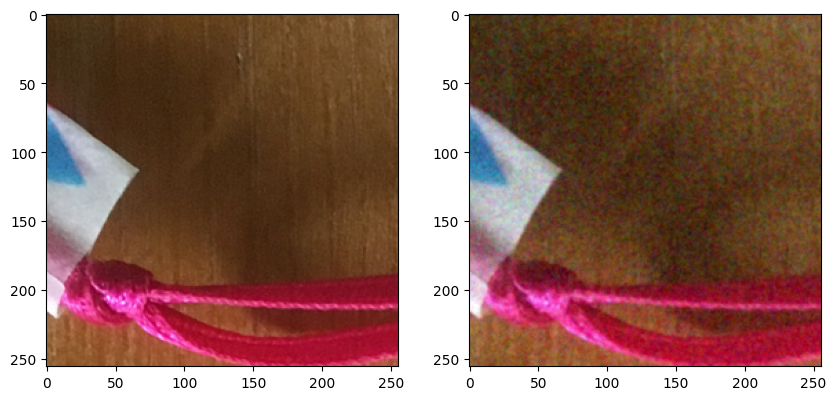

In [10]:
fig, axs = plt.subplots( ncols=2, nrows=1, figsize=(10, 5))
axs[0].imshow(img_true)
axs[1].imshow(img_recon)
plt.show()

# 01

In [2]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, Adadelta, SGD
from torch.profiler import profile, record_function, ProfilerActivity

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution
import model_MMGLR_fast as model_structure

In [17]:
LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test12/logs/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'training00.log'), 
    level=logging.INFO
)

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test12/checkpoints/")
VERBOSE_RATE = 1000

CONNECTION_FLAGS = np.array([
    1,1,1,
    1,0,1,
    1,1,1,
]).reshape((3,3))

# CONNECTION_FLAGS = np.array([
#     1,0,1,0,1,
#     0,0,0,0,0,
#     1,0,0,0,1,
#     0,0,0,0,0,
#     1,0,1,0,1,
# ]).reshape((5, 5))

modelConf = {"ModelLightWeightTransformerGLR": {
    "img_height":None,
    "img_width":None,
    "n_blocks":2,
    "n_graphs":5,
    "n_levels":4,
    "device": DEVICE,
    "global_mmglr_confs" : {
        "n_graphs":10,
        "n_levels":4,
        "n_cgd_iters":5,
        "alpha_init":0.5,
        "muy_init": torch.tensor([[0.3], [0.15], [0.05], [0.001]]).to(DEVICE),
        "beta_init":0.1,
        "device":DEVICE,
        "GLR_modules_conf": [
            {"GLRConf":{
                "n_channels": 3,
                "n_node_fts": 6,
                "n_graphs": 10,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
            }},
            {"GLRConf":{
                "n_channels": 3,
                "n_node_fts": 6,
                "n_graphs": 10,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
            }},
            {"GLRConf":{
                "n_channels": 3,
                "n_node_fts": 6,
                "n_graphs": 10,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
            }},
            {"GLRConf":{
                "n_channels": 3,
                "n_node_fts": 6,
                "n_graphs": 10,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
            }},
        ],
        "Extractor_modules_conf":[
            {"ExtractorConf":{
                "n_features_in": 60,
                "n_features_out": 60,
                "n_channels_in": 3,
                "n_channels_out": 3,
                "device": DEVICE
            }},
            {"ExtractorConf":{
                "n_features_in": 60,
                "n_features_out": 60,
                "n_channels_in": 3,
                "n_channels_out": 3,
                "device": DEVICE
            }},
            {"ExtractorConf":{
                "n_features_in": 60,
                "n_features_out": 60,
                "n_channels_in": 3,
                "n_channels_out": 3,
                "device": DEVICE
            }},
        ]}
    }
}

model = model_structure.ModelLightWeightTransformerGLR(**modelConf["ModelLightWeightTransformerGLR"])

s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    print(p.dtype, np.array(p.shape), s)


torch.float32 [2] 2
torch.float32 [ 4 10] 42
torch.float32 [ 5 10] 92
torch.float32 [ 5 10] 142
torch.float32 [10 60  3  3] 5542
torch.float32 [60  3  3  3] 7162
torch.float32 [10  1] 7172
torch.float32 [9 1 3 3] 7253
torch.float32 [10  1] 7263
torch.float32 [9 1 3 3] 7344
torch.float32 [10  1] 7354
torch.float32 [9 1 3 3] 7435
torch.float32 [10  1] 7445
torch.float32 [9 1 3 3] 7526
torch.float32 [3 1 3 3] 7553
torch.float32 [60 60  3  3] 39953
torch.float32 [60] 40013
torch.float32 [3 1 3 3] 40040
torch.float32 [60 60  3  3] 72440
torch.float32 [60] 72500
torch.float32 [3 1 3 3] 72527
torch.float32 [60 60  3  3] 104927
torch.float32 [60] 104987
torch.float32 [ 4 10] 105027
torch.float32 [ 5 10] 105077
torch.float32 [ 5 10] 105127
torch.float32 [10 60  3  3] 110527
torch.float32 [60  3  3  3] 112147
torch.float32 [10  1] 112157
torch.float32 [9 1 3 3] 112238
torch.float32 [10  1] 112248
torch.float32 [9 1 3 3] 112329
torch.float32 [10  1] 112339
torch.float32 [9 1 3 3] 112420
torch.flo

In [10]:
training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0000k.pt')
training_state = torch.load(training_state_path)
model.load_state_dict(training_state["model"])

<All keys matched successfully>

In [15]:
len(training_state["model"].keys())


s = 0
for name, p in training_state["model"].items():
    s += np.prod(np.array(p.shape))
    print(name, p.dtype, np.array(p.shape), s)

cumulative_result_weight torch.float32 [2] 2
light_weight_transformer_blocks.0.muys torch.float32 [ 2 10] 22
light_weight_transformer_blocks.0.alphaCGD torch.float32 [ 5 10] 72
light_weight_transformer_blocks.0.betaCGD torch.float32 [ 5 10] 122
light_weight_transformer_blocks.0.combination_weight.0.weight torch.float32 [10 60  3  3] 5522
light_weight_transformer_blocks.0.patchs_embeding.weight torch.float32 [60  3  3  3] 7142
light_weight_transformer_blocks.0.list_mixtureGLR.0.multiM torch.float32 [10  1] 7152
light_weight_transformer_blocks.0.list_mixtureGLR.0.stats_kernel torch.float32 [9 1 3 3] 7233
light_weight_transformer_blocks.0.list_mixtureGLR.1.multiM torch.float32 [10  1] 7243
light_weight_transformer_blocks.0.list_mixtureGLR.1.stats_kernel torch.float32 [9 1 3 3] 7324
light_weight_transformer_blocks.0.list_Extractor.0.down_sampling_kernel torch.float32 [3 1 3 3] 7351
light_weight_transformer_blocks.0.list_Extractor.0.cnn_layer.0.weight torch.float32 [60 60  3  3] 39751
light

# 02

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.profiler import profile, record_function, ProfilerActivity

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution

In [2]:

LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test13/logs/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'training00.log'), 
    level=logging.INFO
)

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test13/checkpoints/")
VERBOSE_RATE = 1000

(H_train, W_train) = (128, 128)
(H_val, W_val) = (128, 128)
(H_test, W_test) = (496, 996)

train_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="addictive_noise_scale",
    lambda_noise=25.0,
    patch_size=H_train,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

validation_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/CBSD68_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_val,
    patch_overlap_size=W_val//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

test_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_test,
    patch_overlap_size=0,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)


data_train_batched = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, num_workers=4
)

data_valid_batched = torch.utils.data.DataLoader(
    validation_dataset, batch_size=16, num_workers=4
)

data_test_batched = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=4
)

In [3]:
import itertools
import collections
import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.profiler import profile, record_function, ProfilerActivity
# torch.set_default_dtype(torch.float64)

from einops import rearrange



class CustomLayerNorm(nn.Module):
    def __init__(self, nchannels):
        super(CustomLayerNorm, self).__init__()
        
        self.nchannels = nchannels
        self.weighted_transform = nn.Conv2d(nchannels, nchannels, kernel_size=1, stride=1, groups=nchannels, bias=False)

    def forward(self, x):
        # bz, nchannels, h, w = x.shape
        sigma = x.var(dim=1, keepdim=True, correction=1)
        # bz, 1, h, w = sigma.shape
        return self.weighted_transform(x / torch.sqrt(sigma+1e-5))
    


# class GGLRFast(nn.Module):
#     def __init__(self, 
#             n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
#         ):
#         super(GGLRFast, self).__init__()

#         self.device = device
#         self.n_channels        = n_channels
#         self.n_node_fts        = n_node_fts
#         self.n_graphs          = n_graphs
#         self.n_edges           = (connection_window == 1).sum()
#         self.connection_window = connection_window
#         self.buffer_size       = connection_window.sum()

#         # edges type from connection_window
#         window_size = connection_window.shape[0]
#         connection_window = connection_window.reshape((-1))
#         m = np.arange(window_size)-window_size//2
#         edge_delta = np.array(
#             list(itertools.product(m, m)),
#             dtype=np.int32
#         )
#         self.edge_delta = edge_delta[connection_window == 1]
        
#         self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


#         ### Trainable parameters
#         # features on nodes #self.n_node_fts
#         self.multiM = Parameter(
#             (torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32))*M_diag_init,
#             requires_grad=True,
#         )

#         #############
#         avg_kernel = 1.0 * torch.tensor([
#             [0.0, 0.0, 0.0],
#             [0.0, 1.0, 0.0],
#             [0.0, 0.0, 0.0],
#         ])
#         delta_x = 0.5 * torch.tensor([
#             [0.0, 0.0, 0.0],
#             [0.0,-1.0, 1.0],
#             [0.0, 0.0, 0.0],
#         ])
#         delta_y = 0.5 * torch.tensor([
#             [0.0, 0.0, 0.0],
#             [0.0,-1.0, 0.0],
#             [0.0, 1.0, 0.0],
#         ])
#         kernel = []
#         for r in range(self.n_channels):
#             kernel.append(avg_kernel[np.newaxis, np.newaxis, :, :])
#             kernel.append(delta_x[np.newaxis, np.newaxis, :, :])
#             kernel.append(delta_y[np.newaxis, np.newaxis, :, :])

#         kernel = torch.concat(kernel, axis=0).to(self.device)
#         self.stats_kernel = Parameter(
#             torch.ones((3*self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel,
#             requires_grad=True,
#         )

#     def get_neighbors_pixels(self, img_features):
#         _, _, H, W = img_features.shape
#         padH, padW = self.pad_dim_hw
#         img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
#         neighbors_pixels = []
#         for shift_h, shift_w in self.edge_delta:
#             fromh = padH + shift_h
#             toh = padH + shift_h + H
#             fromw = padW + shift_w
#             tow = padW + shift_w + W
            
#             neighbors_pixels.append(
#                 img_features_frame[:, :, fromh:toh, fromw:tow]
#             )
#         neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)

#         return neighbors_pixels_features
    

#     def normalize_and_transform_features(self, img_features):
#         batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
#         # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
#         img_features = torch.nn.functional.normalize(img_features, dim=2)

#         img_features_transform = torch.einsum(
#             "bhcHW, hc -> bhcHW", img_features, self.multiM
#         )
    
#         img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

#         return img_features_transform


#     def extract_edge_weights(self, img_features):
        
#         batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

#         img_features = self.normalize_and_transform_features(img_features)
#         img_features_neighbors = self.get_neighbors_pixels(img_features)

#         features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
#         features_similarity = features_similarity.view(
#             batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
#         ).sum(axis=2)

#         features_similarity = torch.clip(features_similarity, max=10, min=-10)
        
#         edge_weights = torch.exp(features_similarity)
#         node_degree = edge_weights.sum(axis=2)
#         norm_factor = 1.0 / torch.sqrt(node_degree)
#         norm_factor_neighbors = self.get_neighbors_pixels(norm_factor)
#         edge_weights_norm = norm_factor[:, :, None, :, :] * edge_weights * norm_factor_neighbors

#         # norm_factor = 1.0 / node_degree
#         # edge_weights_norm = norm_factor[:, :, None, :, :] * edge_weights

#         return edge_weights_norm, node_degree
    


#     def op_L_norm(self, img_signals, edge_weights, node_degree):

#         batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
#         img_features_neighbors = self.get_neighbors_pixels(
#             img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
#         ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
#         Wx = torch.einsum(
#             "bhceHW, bheHW -> bhcHW", img_features_neighbors, edge_weights
#         )
#         output = img_signals - Wx
#         return output

    
#     def stats_conv(self, patchs):
#         batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
#         temp_patch = patchs.view(batch_size*n_graphs, c_size, h_size, w_size)
#         temp_patch = nn.functional.pad(temp_patch, (1,1,1,1), 'reflect')
#         temp_out_patch = nn.functional.conv2d(
#             temp_patch,
#             weight=self.stats_kernel,
#             stride=1,
#             padding=0,
#             dilation=1,
#             groups=self.n_channels,
#         )
#         out_patch = temp_out_patch.view(batch_size, n_graphs, 3*c_size, h_size, w_size)
#         return out_patch

#     def stats_conv_transpose(self, patchs):
#         batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
#         temp_patch = patchs.reshape(batch_size*n_graphs, c_size, h_size, w_size)
#         temp_out_patch = nn.functional.conv_transpose2d(
#             temp_patch,
#             weight=self.stats_kernel,
#             stride=1,
#             padding=1,
#             dilation=1,
#             groups=self.n_channels,
#         )
#         out_patch = temp_out_patch.view(batch_size, n_graphs, c_size//3, h_size, h_size)
#         return out_patch


#     def forward(self, patchs, edge_weights, node_degree):
#         # with record_function("GLR:forward"): 
#         # F
#         # batch_size, n_graphs, c_size, h_size, w_size = patchs.shape

#         patchs = self.stats_conv(patchs)
#         # L
#         output_patchs = self.op_L_norm(patchs, edge_weights, node_degree)
        
#         # F^T
#         output_patchs = self.stats_conv_transpose(output_patchs)
#         return output_patchs
    

class GLRFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
        ):
        super(GLRFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


        ### Trainable parameters
        # features on nodes #self.n_node_fts
        self.multiM = Parameter(
            torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32)*M_diag_init,
            requires_grad=True,
        )


    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        neighbors_pixels = []
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            neighbors_pixels.append(
                img_features_frame[:, :, fromh:toh, fromw:tow]
            )
        neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)

        return neighbors_pixels_features
    

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hc -> bhcHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)

        # features_similarity = torch.clip(features_similarity, max=10, min=-10)
        
        edge_weights = torch.exp(features_similarity)
        node_degree = edge_weights.sum(axis=2)
        
        norm_factor = 1.0 / torch.sqrt(node_degree)
        norm_factor_neighbors = self.get_neighbors_pixels(norm_factor)
        edge_weights_norm = norm_factor[:, :, None, :, :] * edge_weights * norm_factor_neighbors

        # norm_factor = 1.0 / node_degree
        # edge_weights_norm = norm_factor[:, :, None, :, :] * edge_weights

        return edge_weights_norm, node_degree
    


    def op_L_norm(self, img_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Wx = torch.einsum(
            "bhceHW, bheHW -> bhcHW", img_features_neighbors, edge_weights
        )
        output = img_signals - Wx
        return output




    def forward(self, patchs, edge_weights, node_degree):
        # with record_function("GLR:forward"): 
        # F
        # batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
        # L
        output_patchs = self.op_L_norm(patchs, edge_weights, node_degree)

        return output_patchs
    


class MixtureGGLR(nn.Module):
    def __init__(self, 
            nchannels_in,
            n_graphs,
            n_node_fts,
            connection_window,
            n_cgd_iters,
            alpha_init,
            beta_init,
            muy_init,
            device
        ):
        super(MixtureGGLR, self).__init__()

        self.device       = device
        self.n_graphs     = n_graphs
        self.n_node_fts   = n_node_fts
        self.n_total_fts  = n_graphs * n_node_fts
        self.n_cgd_iters  = n_cgd_iters
        self.nchannels_in = nchannels_in
        self.connection_window = connection_window



        self.skip_connect_weight_final = Parameter(
            torch.ones((2), device=self.device, dtype=torch.float32) * torch.tensor([0.5, 0.5]).to(self.device),
            requires_grad=True
        )

        self.muys = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * muy_init,
            requires_grad=True,
        )

        self.alphaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * alpha_init,
            requires_grad=True
        )

        self.betaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * beta_init,
            requires_grad=True
        )

        self.patchs_features_extraction = nn.Sequential(
            CustomLayerNorm(self.nchannels_in),
            nn.Conv2d(
                self.nchannels_in,
                self.n_total_fts, 
                kernel_size=1,
                stride=1,
                padding=0,
                padding_mode="replicate",
                bias=False
            ),
        ).to(self.device)

        self.combination_weight = nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_total_fts, 
                out_channels=self.n_graphs, 
                kernel_size=3,
                stride=1,
                padding=1,
                padding_mode="replicate",
                bias=False
            ),
            nn.Softmax(dim=1)
        ).to(self.device)

        self.GGLRmodule = GLRFast(
            n_channels=self.nchannels_in,
            n_node_fts=self.n_node_fts,
            n_graphs=self.n_graphs,
            connection_window=self.connection_window,
            device=self.device,
            M_diag_init=1.0
        )



    def apply_lightweight_transformer(self, patchs, graph_weights, graph_degree):

        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape 
        patchs = patchs.contiguous()

        Lpatchs = self.GGLRmodule(patchs, graph_weights, graph_degree)
        Lpatchs = torch.einsum(
            "bHchw, H -> bHchw", Lpatchs, self.muys
        )
        output = patchs + Lpatchs

        return output
    

    def forward(self, patchs):
        # with record_function("MultiScaleMixtureGLR:forward"): 
        # print("#"*80)
        # patchs = patchs.permute(dims=(0, 3, 1, 2))
        # patchs = patchs.contiguous()
        # patchs = self.images_domain_to_abtract_domain(patchs)
        # print(f"patchs.shape={patchs.shape}")
        batch_size, c_size, h_size, w_size = patchs.shape

        #####
        ## Graph low pass filter
        features_patchs = self.patchs_features_extraction(patchs)
        bz, nfts, h, w = features_patchs.shape
        gW, gD = self.GGLRmodule.extract_edge_weights(
            features_patchs.view((bz, self.GGLRmodule.n_graphs, self.GGLRmodule.n_node_fts, h, w))
        )

        output = patchs[:, None, :, :, :]
        system_residual = output -  self.apply_lightweight_transformer(output, gW, gD)
        update = system_residual

        for iter in range(self.n_cgd_iters):
            A_mul_update = self.apply_lightweight_transformer(update, gW, gD)
            output = output + self.alphaCGD[iter, None, :, None, None, None] * update
            system_residual = system_residual - self.alphaCGD[iter, None, :, None, None, None] * A_mul_update
            update = system_residual + self.betaCGD[iter, None, :, None, None, None] * update

        score = self.combination_weight(features_patchs)
        output = torch.einsum(
            "bgchw, bghw -> bchw", output, score
        )

        final_output = self.skip_connect_weight_final[0] * output
        final_output += self.skip_connect_weight_final[1] * patchs
    
        return final_output
    
##########################################################################
##---------- MultiscaleLightWeightTransformer -----------------------
class MultiscaleLightWeightTransformer(nn.Module):
    def __init__(self, 
        inp_channels=3, 
        out_channels=3, 
        n_abtract_channels=48,
        num_blocks_per_level=[4,6,6,8], 
        n_graphs_per_level=[1,2,4,8],
        n_cgd_per_level=[5,5,5,5],
        num_blocks_output = 4,
        device=torch.device("cpu")
    ):  
        
        super(MultiscaleLightWeightTransformer, self).__init__()
        self.device = device
        CONNECTION_FLAGS = np.array([
            1,1,1,
            1,1,1,
            1,1,1,
        ]).reshape((3,3))

        self.skip_connect_weight_final = Parameter(
            torch.ones((2), device=self.device, dtype=torch.float32) * torch.tensor([0.5, 0.5]).to(self.device),
            requires_grad=True
        )


        n_abtract_channels_01 = n_abtract_channels
        self.patch_embeding   = nn.Conv2d(
            inp_channels, n_abtract_channels_01, 
            kernel_size=3, stride=1, padding=1, bias=False
        ).to(self.device)

        self.denoise_level_01 = nn.Sequential(*[
            MixtureGGLR(**{
                "nchannels_in": n_abtract_channels_01,
                "n_graphs": n_graphs_per_level[0],
                "n_node_fts": n_abtract_channels_01 // n_graphs_per_level[0],
                "connection_window": CONNECTION_FLAGS,
                "n_cgd_iters": n_cgd_per_level[0],
                "alpha_init": 0.5,
                "beta_init": 0.1,
                "muy_init": 0.1,
                "device": self.device
            }) 
            for i in range(num_blocks_per_level[0])
        ]).to(self.device)

        self.denoise_decode_level_01 = nn.Sequential(*[
            MixtureGGLR(**{
                "nchannels_in": n_abtract_channels_01,
                "n_graphs": n_graphs_per_level[0],
                "n_node_fts": n_abtract_channels_01 // n_graphs_per_level[0],
                "connection_window": CONNECTION_FLAGS,
                "n_cgd_iters": n_cgd_per_level[0],
                "alpha_init": 0.5,
                "beta_init": 0.1,
                "muy_init": 0.1,
                "device": self.device
            }) 
            for i in range(num_blocks_per_level[0])
        ]).to(self.device)

        n_abtract_channels_02 = n_abtract_channels_01 * 2
        self.down_sampling_01_02 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_abtract_channels_01, 
                out_channels=n_abtract_channels_02//4, 
                kernel_size=3, stride=1, padding=1, dilation=1,
                padding_mode="replicate", bias=False
            ),
            nn.PixelUnshuffle(2)
        ).to(self.device)
        self.denoise_level_02 = nn.Sequential(*[
            MixtureGGLR(**{
                "nchannels_in": n_abtract_channels_02,
                "n_graphs": n_graphs_per_level[1],
                "n_node_fts": n_abtract_channels_02 // n_graphs_per_level[1],
                "connection_window": CONNECTION_FLAGS,
                "n_cgd_iters": n_cgd_per_level[1],
                "alpha_init": 0.5,
                "beta_init": 0.1,
                "muy_init": 0.1,
                "device": self.device
            }) 
            for i in range(num_blocks_per_level[1])
        ]).to(self.device)
        self.combine_channels_01 = nn.Conv2d(
            int(n_abtract_channels_01*2), int(n_abtract_channels_01), 
            kernel_size=1, bias=False
        ).to(self.device)
        self.up_sampling_02_01 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_abtract_channels_02,
                out_channels=n_abtract_channels_01*4,
                kernel_size=3, stride=1, padding=1, #output_padding=1, 
                padding_mode='zeros', bias=False,
            ),
            nn.PixelShuffle(2)
        ).to(self.device)
        self.denoise_decode_level_02 = nn.Sequential(*[
            MixtureGGLR(**{
                "nchannels_in": n_abtract_channels_02,
                "n_graphs": n_graphs_per_level[1],
                "n_node_fts": n_abtract_channels_02 // n_graphs_per_level[1],
                "connection_window": CONNECTION_FLAGS,
                "n_cgd_iters": n_cgd_per_level[1],
                "alpha_init": 0.5,
                "beta_init": 0.1,
                "muy_init": 0.1,
                "device": self.device
            }) 
            for i in range(num_blocks_per_level[1])
        ]).to(self.device)


        n_abtract_channels_03 = n_abtract_channels_02 * 2
        self.down_sampling_02_03 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_abtract_channels_02, 
                out_channels=n_abtract_channels_03//4, 
                kernel_size=3, stride=1, padding=1, dilation=1,
                padding_mode="replicate", bias=False
            ),
            nn.PixelUnshuffle(2)
        ).to(self.device)
        self.denoise_level_03 = nn.Sequential(*[
            MixtureGGLR(**{
                "nchannels_in": n_abtract_channels_03,
                "n_graphs": n_graphs_per_level[2],
                "n_node_fts": n_abtract_channels_03 // n_graphs_per_level[2],
                "connection_window": CONNECTION_FLAGS,
                "n_cgd_iters": n_cgd_per_level[2],
                "alpha_init": 0.5,
                "beta_init": 0.1,
                "muy_init": 0.1,
                "device": self.device
            }) 
            for i in range(num_blocks_per_level[2])
        ]).to(self.device)
        self.combine_channels_02 = nn.Conv2d(
            int(n_abtract_channels_02*2), int(n_abtract_channels_02), 
            kernel_size=1, bias=False
        ).to(self.device)
        self.up_sampling_03_02 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_abtract_channels_03,
                out_channels=n_abtract_channels_02*4,
                kernel_size=3, stride=1, padding=1, #output_padding=1, 
                padding_mode='zeros', bias=False,
            ),
            nn.PixelShuffle(2)
        ).to(self.device)
        self.denoise_decode_level_03 = nn.Sequential(*[
            MixtureGGLR(**{
                "nchannels_in": n_abtract_channels_03,
                "n_graphs": n_graphs_per_level[2],
                "n_node_fts": n_abtract_channels_03 // n_graphs_per_level[2],
                "connection_window": CONNECTION_FLAGS,
                "n_cgd_iters": n_cgd_per_level[2],
                "alpha_init": 0.5,
                "beta_init": 0.1,
                "muy_init": 0.1,
                "device": self.device
            }) 
            for i in range(num_blocks_per_level[2])
        ]).to(self.device)


        n_abtract_channels_04 = n_abtract_channels_03 * 2
        self.down_sampling_03_04 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_abtract_channels_03, 
                out_channels=n_abtract_channels_04//4, 
                kernel_size=3, stride=1, padding=1, dilation=1,
                padding_mode="replicate", bias=False
            ),
            nn.PixelUnshuffle(2)
        ).to(self.device)

        self.denoise_level_04 = nn.Sequential(*[
            MixtureGGLR(**{
                "nchannels_in": n_abtract_channels_04,
                "n_graphs": n_graphs_per_level[3],
                "n_node_fts": n_abtract_channels_04 // n_graphs_per_level[3],
                "connection_window": CONNECTION_FLAGS,
                "n_cgd_iters": n_cgd_per_level[3],
                "alpha_init": 0.5,
                "beta_init": 0.1,
                "muy_init": 0.1,
                "device": self.device
            }) 
            for i in range(num_blocks_per_level[3])
        ]).to(self.device)
        self.combine_channels_03 = nn.Conv2d(
            int(n_abtract_channels_03*2), int(n_abtract_channels_03), 
            kernel_size=1, bias=False
        ).to(self.device)
        self.up_sampling_04_03 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_abtract_channels_04,
                out_channels=n_abtract_channels_03*4,
                kernel_size=3, stride=1, padding=1, #output_padding=1, 
                padding_mode='zeros', bias=False,
            ),
            nn.PixelShuffle(2)
        ).to(self.device)


        ###################################################################
        self.final_combine_channel_output = nn.Conv2d(
            int(n_abtract_channels_01), int(out_channels),
            kernel_size=1, bias=False
        ).to(self.device)

        self.denoise_level_output = nn.Sequential(*[
            MixtureGGLR(**{
                "nchannels_in": 3,
                "n_graphs": 4,
                "n_node_fts": n_abtract_channels // 4,
                "connection_window": CONNECTION_FLAGS,
                "n_cgd_iters": 5,
                "alpha_init": 0.5,
                "beta_init": 0.1,
                "muy_init": 0.1,
                "device": self.device
            }) 
            for i in range(num_blocks_output)
        ]).to(self.device)

    def forward(self, patchs):

        encode_01 = self.patch_embeding(patchs)
        denoised_encode_01 = self.denoise_level_01(encode_01)

        encode_02 = self.down_sampling_01_02(denoised_encode_01)
        denoised_encode_02 = self.denoise_level_02(encode_02)

        encode_03 = self.down_sampling_02_03(denoised_encode_02)
        denoised_encode_03 = self.denoise_level_03(encode_03)

        encode_04 = self.down_sampling_03_04(denoised_encode_03)
        denoised_encode_04 = self.denoise_level_04(encode_04)

        decode_03 = self.up_sampling_04_03(denoised_encode_04)
        denoised_decode_03 = torch.cat([decode_03, denoised_encode_03], 1)
        denoised_decode_03 = self.combine_channels_03(denoised_decode_03)
        denoised_decode_03 = self.denoise_decode_level_03(denoised_decode_03)

        decode_02 = self.up_sampling_03_02(denoised_decode_03)
        denoised_decode_02 = torch.cat([decode_02, denoised_encode_02], 1)
        denoised_decode_02 = self.combine_channels_02(denoised_decode_02)
        denoised_decode_02 = self.denoise_decode_level_02(denoised_decode_02)


        decode_01 = self.up_sampling_02_01(denoised_decode_02)
        denoised_decode_01 = torch.cat([decode_01, denoised_encode_01], 1)
        denoised_decode_01 = self.combine_channels_01(denoised_decode_01)
        denoised_decode_01 = self.denoise_decode_level_01(denoised_decode_01)
        
        # final_output = self.final_combine_channel_output(denoised_decode_01)
        final_output = self.skip_connect_weight_final[0] * self.final_combine_channel_output(denoised_decode_01)
        final_output += self.skip_connect_weight_final[1] * patchs

        final_output = self.denoise_level_output(final_output)
    
        return final_output
        

In [4]:

CONNECTION_FLAGS = np.array([
    1,1,1,
    1,0,1,
    1,1,1,
]).reshape((3,3))

# modelConf = {
#     "nchannels_in": 3,
#     "n_graphs": 4,
#     "n_node_fts": 12,
#     "connection_window": CONNECTION_FLAGS,
#     "n_cgd_iters": 5,
#     "alpha_init": 0.5,
#     "beta_init": 0.1,
#     "muy_init": 0.1,
#     "device": DEVICE
# }

# model = MixtureGGLR(**modelConf)

# network_g:
#   type: Restormer
#   inp_channels: 3
#   out_channels: 3
#   dim: 48
#   num_blocks: [4,6,6,8]
#   num_refinement_blocks: 4
#   heads: [1,2,4,8]
#   ffn_expansion_factor: 2.66
#   bias: False
#   LayerNorm_type: BiasFree
#   dual_pixel_task: False



modelConf = {
    "inp_channels": 3, 
    "out_channels": 3, 
    "n_abtract_channels": 48,
    "num_blocks_per_level": [2, 3, 3, 4], 
    "n_graphs_per_level": [2, 4, 4, 8],
    "n_cgd_per_level": [2, 2, 2, 2],
    "num_blocks_output": 4,
    "device": DEVICE
}

model = MultiscaleLightWeightTransformer(**modelConf)
s = 0
for name, p in model.state_dict().items():
    s += np.prod(np.array(p.shape))
    # print(name, np.array(p.shape), s)
print(f"total {s} parameters")

criterian = nn.L1Loss()
optimizer = AdamW(
    model.parameters(),
    lr=0.001,
    eps=1e-08
)

total 4866630 parameters


In [8]:
i=0
for patchs_noisy, patchs_true in data_train_batched:
    s = time.time()
    optimizer.zero_grad()
    patchs_noisy = patchs_noisy.to(DEVICE)
    patchs_true = patchs_true.to(DEVICE) 
    reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    loss_value = criterian(reconstruct_patchs, patchs_true)
    loss_value.backward()
    optimizer.step()

    img_true = np.clip(patchs_true.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    img_recon = np.clip(reconstruct_patchs.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    train_mse_value = np.square(img_true- img_recon).mean()
    train_psnr = 10 * np.log10(1/train_mse_value)
    print(f"iter={i} time={time.time()-s} psnr={train_psnr} mse={train_mse_value}")
    i+=1

    if i == 800:
        break

iter=0 time=0.7747502326965332 psnr=25.782890484759964 mse=0.0026406506642748643
iter=1 time=0.7577438354492188 psnr=26.233585287505683 mse=0.002380353573877936
iter=2 time=0.758333683013916 psnr=25.444370745951876 mse=0.0028547161067771928
iter=3 time=0.7570788860321045 psnr=25.839997202299543 mse=0.002606155228868793
iter=4 time=0.7620549201965332 psnr=27.27727339884126 mse=0.0018718569666133975
iter=5 time=0.7607238292694092 psnr=25.383572590555595 mse=0.002894961156779378
iter=6 time=0.7605891227722168 psnr=27.76764783610797 mse=0.0016719959317389743
iter=7 time=0.7584755420684814 psnr=22.810878430969407 mse=0.005234945406221723
iter=8 time=0.759666919708252 psnr=25.697311518726803 mse=0.002693201502775577
iter=9 time=0.7620549201965332 psnr=27.71093908181813 mse=0.0016939714707158986
iter=10 time=0.7576754093170166 psnr=26.21915133701242 mse=0.002388277935184939
iter=11 time=0.7621490955352783 psnr=27.672534567742545 mse=0.001709017631406516
iter=12 time=0.7406244277954102 psnr=29

In [15]:
s = 0
for name, p in model.state_dict().items():
    s += np.prod(np.array(p.shape))
    print(name, np.array(p.shape), s)
    print(p)

print(f"total {s} parameters")

skip_connect_weight_final [2] 2
tensor([0.5020, 0.4960], device='cuda:0')
patch_embeding.weight [48  3  3  3] 1298
tensor([[[[-0.0596, -0.0669,  0.1572],
          [-0.1971, -0.1448, -0.0291],
          [ 0.1005, -0.0526, -0.1097]],

         [[-0.0565,  0.0778, -0.0834],
          [-0.1261, -0.0908,  0.1035],
          [ 0.0239,  0.0717,  0.0887]],

         [[-0.1870,  0.0041, -0.0373],
          [ 0.0864,  0.1832, -0.1330],
          [-0.0904, -0.0311, -0.0067]]],


        [[[ 0.0283, -0.1041, -0.1264],
          [-0.0123, -0.0257, -0.1087],
          [-0.0454,  0.1400,  0.0474]],

         [[-0.0833, -0.0358,  0.1827],
          [-0.1583, -0.0673,  0.1778],
          [ 0.0151,  0.1049, -0.1342]],

         [[-0.0083,  0.0481, -0.0313],
          [-0.0226,  0.1121,  0.1353],
          [-0.1429, -0.1106, -0.1607]]],


        [[[-0.0460,  0.1489,  0.1455],
          [-0.1050, -0.0631,  0.0048],
          [ 0.0920, -0.0438, -0.0338]],

         [[-0.0828, -0.0402,  0.0340],
         

In [8]:
model.eval()
list_val_mse = []
val_i = 0
for val_patchs_noisy, val_patchs_true in data_valid_batched:
    s = time.time()
    with torch.no_grad():
        val_patchs_noisy = val_patchs_noisy.to(DEVICE)
        val_patchs_true = val_patchs_true.to(DEVICE) 

        reconstruct_patchs = model(val_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(val_patchs_true.cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs.cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        val_mse_value = np.square(img_true- img_recon).mean()
        list_val_mse.append(val_mse_value)
        print(f"val_i={val_i} time={time.time()-s} val_i_psnr_value={10 * np.log10(1/val_mse_value)}")
    val_i+=1

psnr_validation = 10 * np.log10(1/np.array(list_val_mse))
print(f"FINISH VALIDATION EPOCH {0} - iter={i} -  psnr_validation={np.mean(psnr_validation)}")
# model.train()

val_i=0 time=0.3781585693359375 val_i_psnr_value=24.944163441513663
val_i=1 time=0.36709022521972656 val_i_psnr_value=25.809439807282303
val_i=2 time=0.3674311637878418 val_i_psnr_value=25.63905522782557
val_i=3 time=0.3673133850097656 val_i_psnr_value=25.297921925045138
val_i=4 time=0.36689090728759766 val_i_psnr_value=24.771960917940806
val_i=5 time=0.36739039421081543 val_i_psnr_value=25.580079707537898
val_i=6 time=0.36721181869506836 val_i_psnr_value=25.28763920418852
val_i=7 time=0.36705613136291504 val_i_psnr_value=25.695438786072295
val_i=8 time=0.366901159286499 val_i_psnr_value=25.782928915713775
val_i=9 time=0.36690688133239746 val_i_psnr_value=25.67353560220328
val_i=10 time=0.3672969341278076 val_i_psnr_value=26.210544739219657
val_i=11 time=0.36736273765563965 val_i_psnr_value=25.596930084977302
val_i=12 time=0.36714673042297363 val_i_psnr_value=25.522419071805484
val_i=13 time=0.3670346736907959 val_i_psnr_value=25.272531651666604
val_i=14 time=0.3669745922088623 val_i_p

In [9]:
# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(test_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")
    test_i+=1

psnr_testing = 10 * np.log10(1/np.array(list_test_mse))
print(f"FINISH TESING EPOCH {0} - iter={i} -  psnr_testing={np.mean(psnr_testing)}")
# model.train()

test_i=0 time=1.20802903175354 test_i_psnr_value=11.681498375846768
test_i=1 time=1.1869919300079346 test_i_psnr_value=11.168975923313461
test_i=2 time=1.1883716583251953 test_i_psnr_value=15.542574950749454
test_i=3 time=1.1990330219268799 test_i_psnr_value=13.969768369627944
test_i=4 time=1.195774793624878 test_i_psnr_value=13.490290404801799
test_i=5 time=1.1900615692138672 test_i_psnr_value=14.11321497000509
test_i=6 time=1.1980559825897217 test_i_psnr_value=12.315595930107488
test_i=7 time=1.1854233741760254 test_i_psnr_value=14.398577852140289
test_i=8 time=1.1938629150390625 test_i_psnr_value=12.046938903711272
test_i=9 time=1.192049264907837 test_i_psnr_value=10.255797352467512
test_i=10 time=1.1899256706237793 test_i_psnr_value=18.978741089609013
test_i=11 time=1.1889402866363525 test_i_psnr_value=14.818721405939906
test_i=12 time=1.1930160522460938 test_i_psnr_value=13.544866882943724
test_i=13 time=1.1930294036865234 test_i_psnr_value=14.179075401217563
test_i=14 time=1.1963

In [10]:

img_noisy = np.clip(test_patchs_noisy[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)

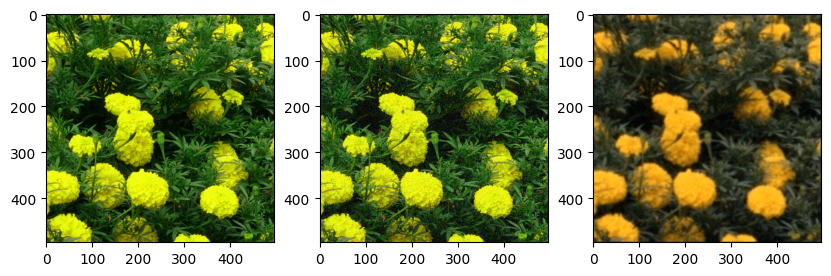

In [14]:
fig, axs = plt.subplots( ncols=3, nrows=1, figsize=(10, 5))
axs[0].imshow(img_true)
axs[1].imshow(img_noisy)
axs[2].imshow(img_recon)
plt.show()

# 03

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.profiler import profile, record_function, ProfilerActivity

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution

LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test_restormer/logs/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'training00.log'), 
    level=logging.INFO
)

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test_restormer/checkpoints/")
VERBOSE_RATE = 1000

(H_train, W_train) = (128, 128)
(H_val, W_val) = (128, 128)
(H_test, W_test) = (496, 996)

train_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="addictive_noise_scale",
    lambda_noise=25.0,
    patch_size=H_train,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

validation_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/CBSD68_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_val,
    patch_overlap_size=W_val//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

test_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_test,
    patch_overlap_size=0,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)


data_train_batched = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, num_workers=4
)

data_valid_batched = torch.utils.data.DataLoader(
    validation_dataset, batch_size=16, num_workers=4
)

data_test_batched = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=4
)

In [ ]:
## Restormer: Efficient Transformer for High-Resolution Image Restoration
## Syed Waqas Zamir, Aditya Arora, Salman Khan, Munawar Hayat, Fahad Shahbaz Khan, and Ming-Hsuan Yang
## https://arxiv.org/abs/2111.09881


import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers
import numpy as np
import itertools

from einops import rearrange


class GLRFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
        ):
        super(GLRFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


        ### Trainable parameters
        # features on nodes #self.n_node_fts
        self.multiM = Parameter(
            torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32)*M_diag_init,
            requires_grad=True,
        )


    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        neighbors_pixels = []
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            neighbors_pixels.append(
                img_features_frame[:, :, fromh:toh, fromw:tow]
            )
        neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)

        return neighbors_pixels_features
    

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hc -> bhcHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)

        # features_similarity = torch.clip(features_similarity, max=10, min=-10)

        edge_weights_norm = nn.functional.softmax(features_similarity, dim=2) 
        node_degree = edge_weights_norm.sum(axis=2)

        # edge_weights = torch.exp(features_similarity)
        # node_degree = edge_weights.sum(axis=2)
        
        # norm_factor = 1.0 / torch.sqrt(node_degree)
        # norm_factor_neighbors = self.get_neighbors_pixels(norm_factor)
        # edge_weights_norm = norm_factor[:, :, None, :, :] * edge_weights * norm_factor_neighbors

        # norm_factor = 1.0 / node_degree
        # edge_weights_norm = norm_factor[:, :, None, :, :] * edge_weights

        # edge_weights_norm = edge_weights

        return edge_weights_norm, node_degree
    


    def op_L_norm(self, img_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Wx = torch.einsum(
            "bhceHW, bheHW -> bhcHW", img_features_neighbors, edge_weights
        )
        output = img_signals - Wx
        return output




    def forward(self, patchs, edge_weights, node_degree):
        # with record_function("GLR:forward"): 
        # F
        # batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
        # L
        output_patchs = self.op_L_norm(patchs, edge_weights, node_degree)

        return output_patchs
    


class MixtureGGLR(nn.Module):
    def __init__(self, 
            nchannels_in,
            n_graphs,
            n_node_fts,
            connection_window,
            n_cgd_iters,
            alpha_init,
            beta_init,
            muy_init,
            device
        ):
        super(MixtureGGLR, self).__init__()

        self.device       = device
        self.n_graphs     = n_graphs
        self.n_node_fts   = n_node_fts
        self.n_total_fts  = n_graphs * n_node_fts
        self.n_cgd_iters  = n_cgd_iters
        self.nchannels_in = nchannels_in
        self.connection_window = connection_window

        self.muys = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * muy_init,
            requires_grad=True,
        )

        self.alphaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * alpha_init,
            requires_grad=True
        )

        self.betaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * beta_init,
            requires_grad=True
        )

        self.patchs_features_extraction = nn.Sequential(
            nn.Conv2d(
                self.nchannels_in,
                self.n_total_fts, 
                kernel_size=1,
                stride=1,
                padding=0,
                padding_mode="replicate",
                bias=False
            ),
        ).to(self.device)
        

        self.combination_weight = nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_total_fts, 
                out_channels=self.n_graphs, 
                kernel_size=1,
                stride=1,
                padding=0,
                padding_mode="replicate",
                bias=False
            ),
            nn.Softmax(dim=1)
        ).to(self.device)

        self.GGLRmodule = GLRFast(
            n_channels=self.nchannels_in,
            n_node_fts=self.n_node_fts,
            n_graphs=self.n_graphs,
            connection_window=self.connection_window,
            device=self.device,
            M_diag_init=1.0
        )



    def apply_lightweight_transformer(self, patchs, graph_weights, graph_degree):

        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape 
        patchs = patchs.contiguous()

        Lpatchs = self.GGLRmodule(patchs, graph_weights, graph_degree)
        Lpatchs = torch.einsum(
            "bHchw, H -> bHchw", Lpatchs, self.muys
        )
        output = patchs + Lpatchs

        return output
    

    def forward(self, patchs):
        # with record_function("MultiScaleMixtureGLR:forward"): 
        # print("#"*80)
        # patchs = patchs.permute(dims=(0, 3, 1, 2))
        # patchs = patchs.contiguous()
        # patchs = self.images_domain_to_abtract_domain(patchs)
        # print(f"patchs.shape={patchs.shape}")
        batch_size, c_size, h_size, w_size = patchs.shape

        #####
        ## Graph low pass filter
        features_patchs = self.patchs_features_extraction(patchs)
        bz, nfts, h, w = features_patchs.shape
        gW, gD = self.GGLRmodule.extract_edge_weights(
            features_patchs.view((bz, self.GGLRmodule.n_graphs, self.GGLRmodule.n_node_fts, h, w))
        )

        # output = patchs[:, None, :, :, :]
        # system_residual = output -  self.apply_lightweight_transformer(output, gW, gD)
        # update = system_residual

        # for iter in range(self.n_cgd_iters):
        #     A_mul_update = self.apply_lightweight_transformer(update, gW, gD)
        #     output = output + self.alphaCGD[iter, None, :, None, None, None] * update
        #     system_residual = system_residual - self.alphaCGD[iter, None, :, None, None, None] * A_mul_update
        #     update = system_residual + self.betaCGD[iter, None, :, None, None, None] * update

        # one step
        output = patchs[:, None, :, :, :]
        system_residual = output -  self.apply_lightweight_transformer(output, gW, gD)
        output = output + self.alphaCGD[0, None, :, None, None, None] * system_residual

        score = self.combination_weight(features_patchs)
        output = torch.einsum(
            "bgchw, bghw -> bchw", output, score
        )

        return output

##########################################################################
## Layer Norm

def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma+1e-5) * self.weight

class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)



##########################################################################
## Gated-Dconv Feed-Forward Network (GDFN)
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x



##########################################################################
## Multi-DConv Head Transposed Self-Attention (MDTA)
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)
        


    def forward(self, x):
        b,c,h,w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q,k,v = qkv.chunk(3, dim=1)   
        
        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)
        
        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        out = self.project_out(out)
        return out



# ##########################################################################
# class TransformerBlock(nn.Module):
#     def __init__(self, dim, num_heads, ffn_expansion_factor, bias, LayerNorm_type):
#         super(TransformerBlock, self).__init__()

#         self.norm1 = LayerNorm(dim, LayerNorm_type)
#         self.attn = Attention(dim, num_heads, bias)
#         self.norm2 = LayerNorm(dim, LayerNorm_type)
#         self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

#     def forward(self, x):
#         x = 0.5*x + 0.5*self.attn(self.norm1(x))
#         x = x + self.ffn(self.norm2(x))

#         return x




##########################################################################
class FFBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor, bias, LayerNorm_type):
        super(FFBlock, self).__init__()

        self.norm1 = LayerNorm(dim, LayerNorm_type)
        # self.attn = Attention(dim, num_heads, bias)


        self.skip_connect_weight_final = Parameter(
            torch.ones((2), dtype=torch.float32) * torch.tensor([0.5, 0.5]),
            requires_grad=True
        )
        CONNECTION_FLAGS = np.array([
            1,1,1,
            1,0,1,
            1,1,1,
        ]).reshape((3,3))
        self.mglr = MixtureGGLR(**{
            "nchannels_in": dim,
            "n_graphs": num_heads,
            "n_node_fts": dim // num_heads,
            "connection_window": CONNECTION_FLAGS,
            "n_cgd_iters": 1,
            "alpha_init": 0.5,
            "beta_init": 0.1,
            "muy_init": 0.1,
            "device": torch.device("cpu")
        })
        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        # x = x + self.mglr(self.norm1(x))
        x = self.skip_connect_weight_final[0] * x + self.skip_connect_weight_final[1] * self.mglr(x)
        x = x + self.ffn(self.norm2(x))

        return x




##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x



##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

    def forward(self, x):
        return self.body(x)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2))

    def forward(self, x):
        return self.body(x)

##########################################################################
##---------- Restormer -----------------------
class Restormer(nn.Module):
    def __init__(self, 
        inp_channels=3, 
        out_channels=3, 
        dim = 48,
        num_blocks = [4,6,6,8], 
        num_refinement_blocks = 4,
        heads = [1,2,4,8],
        ffn_expansion_factor = 2.66,
        bias = False,
        LayerNorm_type = 'WithBias',   ## Other option 'BiasFree'
        dual_pixel_task = False        ## True for dual-pixel defocus deblurring only. Also set inp_channels=6
    ):

        super(Restormer, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[FFBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])
        
        self.down1_2 = Downsample(dim) ## From Level 1 to Level 2
        self.encoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])
        
        self.down2_3 = Downsample(int(dim*2**1)) ## From Level 2 to Level 3
        self.encoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])

        self.down3_4 = Downsample(int(dim*2**2)) ## From Level 3 to Level 4
        self.latent = nn.Sequential(*[FFBlock(dim=int(dim*2**3), num_heads=heads[3], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[3])])
        
        self.up4_3 = Upsample(int(dim*2**3)) ## From Level 4 to Level 3
        self.reduce_chan_level3 = nn.Conv2d(int(dim*2**3), int(dim*2**2), kernel_size=1, bias=bias)
        self.decoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])


        self.up3_2 = Upsample(int(dim*2**2)) ## From Level 3 to Level 2
        self.reduce_chan_level2 = nn.Conv2d(int(dim*2**2), int(dim*2**1), kernel_size=1, bias=bias)
        self.decoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])
        
        self.up2_1 = Upsample(int(dim*2**1))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.decoder_level1 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])
        
        self.refinement = nn.Sequential(*[FFBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_refinement_blocks)])
        
        #### For Dual-Pixel Defocus Deblurring Task ####
        self.dual_pixel_task = dual_pixel_task
        if self.dual_pixel_task:
            self.skip_conv = nn.Conv2d(dim, int(dim*2**1), kernel_size=1, bias=bias)
        ###########################
            
        self.output = nn.Conv2d(int(dim*2**1), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img):

        inp_enc_level1 = self.patch_embed(inp_img)
        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
        inp_enc_level2 = self.down1_2(out_enc_level1)
        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)
        out_enc_level3 = self.encoder_level3(inp_enc_level3) 

        inp_enc_level4 = self.down3_4(out_enc_level3)        
        latent = self.latent(inp_enc_level4) 
                        
        inp_dec_level3 = self.up4_3(latent)
        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
        out_dec_level3 = self.decoder_level3(inp_dec_level3) 

        inp_dec_level2 = self.up3_2(out_dec_level3)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
        out_dec_level2 = self.decoder_level2(inp_dec_level2) 

        inp_dec_level1 = self.up2_1(out_dec_level2)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)
        
        out_dec_level1 = self.refinement(out_dec_level1)

        #### For Dual-Pixel Defocus Deblurring Task ####
        if self.dual_pixel_task:
            out_dec_level1 = out_dec_level1 + self.skip_conv(inp_enc_level1)
            out_dec_level1 = self.output(out_dec_level1)
        ###########################
        else:
            out_dec_level1 = self.output(out_dec_level1) + inp_img


        return out_dec_level1



In [3]:
model = Restormer(**{
    "inp_channels":3, 
    "out_channels":3, 
    "dim": 48,
    "num_blocks": [4,6,6,8], 
    "num_refinement_blocks": 4,
    "heads": [1,2,4,8],
    "ffn_expansion_factor": 2.66,
    "bias": False,
    "LayerNorm_type": 'WithBias',   ## Other option 'BiasFree'
    "dual_pixel_task": False        ## True for dual-pixel defocus deblurring only. Also set inp_channels=6
}).to(DEVICE)


s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

criterian = nn.L1Loss()
optimizer = AdamW(
    model.parameters(),
    lr=0.0001,
    eps=1e-08
)

Init model with total parameters: 20522740


In [4]:
for patchs_noisy, patchs_true in data_train_batched:
    patchs_noisy = patchs_noisy.to(DEVICE)
    patchs_true = patchs_true.to(DEVICE)
    reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    break


In [ ]:
i=0
for patchs_noisy, patchs_true in data_train_batched:
    # with torch.autograd.set_detect_anomaly(True):
    s = time.time()
    optimizer.zero_grad()
    patchs_noisy = patchs_noisy.to(DEVICE)
    patchs_true = patchs_true.to(DEVICE)
    reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    loss_value = criterian(reconstruct_patchs, patchs_true)
    loss_value.backward()
    optimizer.step()

    img_true = np.clip(patchs_true.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    img_recon = np.clip(reconstruct_patchs.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    train_mse_value = np.square(img_true- img_recon).mean()
    train_psnr = 10 * np.log10(1/train_mse_value)
    print(f"iter={i} time={time.time()-s} psnr={train_psnr} mse={train_mse_value}")
    i+=1

    if i == 2000:
        break

iter=0 time=0.9918529987335205 psnr=16.60089974846968 mse=0.0218730842194855
iter=1 time=0.7690966129302979 psnr=18.522480733049232 mse=0.014052446052123033
iter=2 time=0.7722845077514648 psnr=18.98399470567352 mse=0.012635735588984022
iter=3 time=0.7676386833190918 psnr=19.604716611655913 mse=0.01095288023401784
iter=4 time=0.7594079971313477 psnr=19.14390886497537 mse=0.01217892941637499
iter=5 time=0.7626025676727295 psnr=19.983633393855968 mse=0.010037756602473724
iter=6 time=0.7602522373199463 psnr=20.072058484769713 mse=0.009835448111175914
iter=7 time=0.7600362300872803 psnr=19.748728330760663 mse=0.010595639334959899
iter=8 time=0.761798620223999 psnr=19.78266281264795 mse=0.010513170765889451
iter=9 time=0.7620177268981934 psnr=20.187638847031494 mse=0.00957714615811067
iter=10 time=0.7641253471374512 psnr=20.617201872427174 mse=0.008675206329341071
iter=11 time=0.762784481048584 psnr=20.367535194561704 mse=0.009188539371206752
iter=12 time=0.7707598209381104 psnr=20.682992566

In [9]:
s = 0
for name, p in model.state_dict().items():
    s += np.prod(np.array(p.shape))
    print(name, np.array(p.shape), s)
    print(p)

print(f"total {s} parameters")

patch_embed.proj.weight [48  3  3  3] 1296
tensor([[[[-0.0686, -0.0799,  0.1112],
          [-0.0665,  0.0054, -0.0395],
          [ 0.0410,  0.0583,  0.1569]],

         [[-0.1722, -0.0076, -0.1730],
          [-0.1843,  0.0376, -0.0065],
          [-0.1011,  0.1578, -0.1777]],

         [[ 0.1201, -0.1101,  0.0886],
          [ 0.1187,  0.0965, -0.1834],
          [-0.1138, -0.0866, -0.0125]]],


        [[[ 0.0954, -0.1340,  0.0438],
          [ 0.0747, -0.0710, -0.0290],
          [ 0.1838, -0.1679,  0.0308]],

         [[ 0.1561, -0.1893,  0.0771],
          [ 0.1383, -0.1290,  0.1082],
          [ 0.1486,  0.0143, -0.0438]],

         [[-0.0655, -0.1350,  0.0389],
          [ 0.1791,  0.1236,  0.1114],
          [ 0.1081, -0.0940, -0.1716]]],


        [[[-0.1388,  0.1804,  0.1057],
          [ 0.0122,  0.1414, -0.0688],
          [-0.1124, -0.1829, -0.1259]],

         [[-0.0520,  0.1194,  0.1308],
          [ 0.0502,  0.0952,  0.1408],
          [ 0.0119, -0.1389,  0.1591]],

 

In [5]:
model.eval()
list_val_mse = []
val_i = 0
for val_patchs_noisy, val_patchs_true in data_valid_batched:
    s = time.time()
    with torch.no_grad():
        val_patchs_noisy = val_patchs_noisy.to(DEVICE)
        val_patchs_true = val_patchs_true.to(DEVICE) 

        reconstruct_patchs = model(val_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(val_patchs_true.cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs.cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        val_mse_value = np.square(img_true- img_recon).mean()
        list_val_mse.append(val_mse_value)
        print(f"val_i={val_i} time={time.time()-s} val_i_psnr_value={10 * np.log10(1/val_mse_value)}")
    val_i+=1

psnr_validation = 10 * np.log10(1/np.array(list_val_mse))
print(f"FINISH VALIDATION EPOCH {0} - iter={i} -  psnr_validation={np.mean(psnr_validation)}")
# model.train()

val_i=0 time=0.6826162338256836 val_i_psnr_value=26.57091628935924
val_i=1 time=0.6710264682769775 val_i_psnr_value=27.5409889000781
val_i=2 time=0.6725778579711914 val_i_psnr_value=27.08674971364918
val_i=3 time=0.6763350963592529 val_i_psnr_value=26.873703875012698
val_i=4 time=0.6713213920593262 val_i_psnr_value=25.995792016822822
val_i=5 time=0.6722142696380615 val_i_psnr_value=27.191691066877265
val_i=6 time=0.6738667488098145 val_i_psnr_value=26.906901452730963
val_i=7 time=0.6643152236938477 val_i_psnr_value=27.47813806260521
val_i=8 time=0.6717245578765869 val_i_psnr_value=27.33323550872717
val_i=9 time=0.6685709953308105 val_i_psnr_value=27.206048638884866
val_i=10 time=0.6743812561035156 val_i_psnr_value=28.04900270883207
val_i=11 time=0.6726794242858887 val_i_psnr_value=27.291923892271065
val_i=12 time=0.6723458766937256 val_i_psnr_value=27.28854975201535
val_i=13 time=0.6708924770355225 val_i_psnr_value=26.66502235814685
val_i=14 time=0.6721374988555908 val_i_psnr_value=26.

In [7]:
# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(test_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")
    test_i+=1

psnr_testing = 10 * np.log10(1/np.array(list_test_mse))
print(f"FINISH TESING EPOCH {0} - iter={i} -  psnr_testing={np.mean(psnr_testing)}")
# model.train()

test_i=0 time=0.8073067665100098 test_i_psnr_value=28.81594689270087
test_i=1 time=0.7990102767944336 test_i_psnr_value=29.926158589097295
test_i=2 time=0.8026008605957031 test_i_psnr_value=26.350064770651823
test_i=3 time=0.7961115837097168 test_i_psnr_value=29.463523295072264
test_i=4 time=0.7958414554595947 test_i_psnr_value=28.900687103118308
test_i=5 time=0.7989768981933594 test_i_psnr_value=28.466443717891504
test_i=6 time=0.8021795749664307 test_i_psnr_value=28.429674208827148
test_i=7 time=0.7949118614196777 test_i_psnr_value=27.904418806794133
test_i=8 time=0.8018674850463867 test_i_psnr_value=24.982504866291436
test_i=9 time=0.8009469509124756 test_i_psnr_value=27.485447927688366
test_i=10 time=0.8010354042053223 test_i_psnr_value=28.130725965791108
test_i=11 time=0.8023416996002197 test_i_psnr_value=29.309301191047055
test_i=12 time=0.7992115020751953 test_i_psnr_value=26.064388757333067
test_i=13 time=0.7957260608673096 test_i_psnr_value=28.33399866207829
test_i=14 time=0.8

# End
